In [3]:
import pandas as pd
from scipy.interpolate import interp1d
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import price_data as price
import statistics
import time
from datetime import date
import os
from gql import gql, Client
from gql.transport.aiohttp import AIOHTTPTransport
import chart

# Select your transport with a defined url endpoint
transport = AIOHTTPTransport(url="https://saturn.hasura.app/v1/graphql", headers={'x-hasura-admin-secret': 'Rc07SJt4ryC6RyNXDKFRAtFmRkGBbT8Ez3SdaEYsHQoHemCldvs52Kc803oK8X62'})

# Create a GraphQL client using the defined transport
client = Client(transport=transport, fetch_schema_from_transport=True)

async def get_stored_data(symbol,timeframe):
    # Provide a GraphQL query
    split_symbol=symbol.split('/')
    base_currency=split_symbol[0]
    quote_currency=split_symbol[1]
    table=base_currency+quote_currency+'_'+timeframe
    if table=='BTCUSD_1d':
        query = gql(
            """
            query MyQuery {
                BTCUSD_1d {
                    unix
                    close
                    high
                    low
                    open
                }
            }
        """
        )
    elif table=='ETHUSD_1d':
        query = gql(
            """
            query MyQuery {
                ETHUSD_1d {
                    unix
                    close
                    high
                    low
                    open
                }
            }
        """
        )
    elif table=='ETHBTC_1d':
        query = gql(
            """
            query MyQuery {
                ETHBTC_1d {
                    unix
                    close
                    high
                    low
                    open
                }
            }
        """
        )
    else:
        return 'no such table'

    # Execute the query on the transport
    result = await client.execute_async(query)
    candles=result[table]
    df=pd.DataFrame({},columns=['unix','close','high','low','open'])
    for candle in candles:
        df=df.append(candle,ignore_index=True)

    return df.sort_values(by=['unix'], ignore_index=True)

def find_start(timestamps):
    start_found=False
    timestamps=list(map(lambda x:x[0]/1000,timestamps))
    index=len(timestamps)-1
    while not(start_found):
        print(timestamps[index])
        day=date.fromtimestamp(timestamps[index]).weekday()
        if day==0:
            start_found=True
        else:   
            index=index-1
    return index

def read_data(filename):
    raw=pd.read_csv('data/'+filename)
    timestamps=raw['unix']
    for i in range(len(timestamps)):
        if np.log10(timestamps.iloc[i])<12:
            raw.loc[i,'unix']=timestamps[i]*1000
    return raw.sort_values(by=['unix'], ignore_index=True)

month_dictionary={
    'Jan':1,
    'Feb':2,
    'Mar':3,
    'Apr':4,
    'May':5,
    'Jun':6,
    'Jul':7,
    'Aug':8,
    'Sep':9,
    'Oct':10,
    'Nov':11,
    'Dec':12,
}

def parse_data(datestring):
    string=datestring.split('-')
    month=month_dictionary[string[0]]
    day=int(string[1])
    year=int(string[2])
    d=date(year,month,day)

    return time.mktime(d.timetuple())

def process_coincodex_csv(filename):

    raw_data=pd.read_csv('data/'+filename)
    vectorised_parsing=np.vectorize(parse_data)
    timestamps=vectorised_parsing(raw_data['Date'].values)
    df=raw_data
    df['unix']=np.array(timestamps,np.int64)*1000
    df.columns = ['date','open','high','low','close','volume','market cap','unix']
    df.sort_values(by='unix', ignore_index=True, inplace=True)
    df.to_csv('data/Updated_'+filename)

    return df

def conditional_risk(fast, slow):


    min_timestamp=max(fast['unix'].min(),slow['unix'].min())
    trimmed_fast=fast.loc[fast['unix']>=min_timestamp]
    slow=slow.loc[slow['unix']>=min_timestamp]

    if len(trimmed_fast)>len(slow): 
        #different values, ie using a daily for fast and weekly for slow
        if (slow['unix'].max()<trimmed_fast['unix'].max()):
            #add another value to the slow moving avarage to facilitate interpolation
            slow=slow.append({'unix': trimmed_fast['unix'].max(), 'value':slow.iloc[-1]['value']},ignore_index=True)
        f=interp1d(slow['unix'],slow['value'])
        slow_interpolated=f(trimmed_fast['unix'])
        slow=pd.DataFrame({'unix':trimmed_fast['unix'],'value':slow_interpolated})

    gradient=chart.get_gradient(slow)
    uptrend=gradient>0
    slow=slow.iloc[1:,:]
    trimmed_fast=trimmed_fast.iloc[1:,:]


    if ('open' in fast.columns.values.tolist()):
        #using price
        risk_metric=np.divide(trimmed_fast['open'],slow['value'])
    else:
        #using moving average
        risk_metric=np.divide(trimmed_fast['value'],slow['value'])

    print(len(uptrend),len(risk_metric),len(np.array(trimmed_fast['unix'], dtype=np.int64)))
    df=pd.DataFrame({'unix':np.array(trimmed_fast['unix'], dtype=np.int64),'risk_metric':risk_metric, 'uptrend':uptrend})
    uptrend_data=df.loc[df['uptrend']]
    downtrend_data=df.loc[~df['uptrend']]
    u_mean=uptrend_data['risk_metric'].mean()
    u_std=uptrend_data['risk_metric'].std()
    u_risk=(uptrend_data['risk_metric']-u_mean)/u_std
    d_mean=downtrend_data['risk_metric'].mean()
    d_std=downtrend_data['risk_metric'].std()
    d_risk=(downtrend_data['risk_metric']-d_mean)/d_std

    uptrend_series=pd.Series(index=uptrend_data['unix'], data=u_risk.values)
    downtrend_series=pd.Series(index=downtrend_data['unix'], data=d_risk.values)

    return pd.concat([uptrend_series, downtrend_series]) 


In [4]:
btc_price_data= await get_stored_data('BTC/USD','1d')
btc_price_data

,unix,close,high,low,open
0,1.423440e+12,220.61,225.00,215.40,224.22
1,1.423526e+12,220.96,223.88,214.00,220.61
2,1.423613e+12,219.19,224.40,218.10,220.96
3,1.423699e+12,222.60,223.20,217.87,219.19
4,1.423786e+12,236.00,241.76,221.46,222.39
...,...,...,...,...,...
2403,1.631059e+12,46059.00,47361.00,44381.00,46871.00
2404,1.631146e+12,46392.00,47404.00,45513.00,46059.00
2405,1.631232e+12,44859.00,47039.00,44116.00,46392.00
2406,1.631318e+12,45170.00,45994.00,44722.00,44855.00


In [5]:
weekly_candles=price.get_price_data('1w',data=btc_price_data)
weekly_candles

,unix,open,high,low,close
0,1.423958e+12,224.220000,266.84,214.00,234.14
1,1.424563e+12,234.140000,248.98,228.62,236.59
2,1.425168e+12,236.590000,265.00,232.61,261.15
3,1.425773e+12,262.470000,294.00,259.60,275.23
4,1.426378e+12,275.230000,303.96,275.01,286.12
...,...,...,...,...,...
339,1.628986e+12,43782.469031,48141.00,42790.00,47022.00
340,1.629590e+12,47023.000000,49788.00,43992.00,49266.00
341,1.630195e+12,49267.000000,50558.00,46310.00,48800.00
342,1.630800e+12,48801.000000,51928.00,46521.00,51807.00


In [6]:
fast=chart.get_sma(btc_price_data,50)
fast_ema=chart.get_ema(btc_price_data,50)
slow=chart.get_sma(weekly_candles,50)

0.35919977635221734


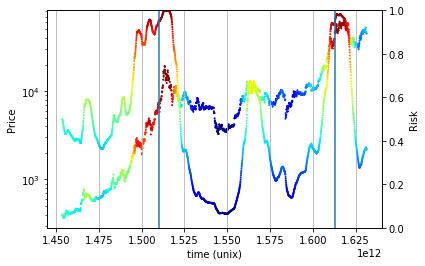

In [53]:
fig, ax1 = plt.subplots()
ax1.set_xlabel('time (unix)')
ax1.set_ylabel('Price')
# ax1.plot(fast['unix'],fast['value'])

risk=chart.risk_indicator(fast_ema,slow)
print(risk.iloc[-1]['value'])
#ax1.plot(btc_price_data['unix'],btc_price_data['open'])
# ax1.plot(fast['unix'],fast['value'])
#ax1.plot(slow['unix'],slow['value'])
ax1.set_yscale('log')
ax1.grid(axis="x")
ax2 = ax1.twinx()
ax2.set_ylabel('Risk')
filtered_price_data=btc_price_data[btc_price_data['unix']>=risk['unix'].min()]
# filtered_risk=risk.loc[risk['value']<0.15]
# ax2.scatter(filtered_risk['unix'],filtered_risk['value'], s=1)
ax2.set_ylim(0,1)
ax2.vlines([1.51*(10**12),1.613*(10**12)],ymin=0, ymax=1)
#ax2.vlines(filtered_risk['unix'],0,btc_price_data['close'].max(), colors='r')

ax1.scatter(filtered_price_data['unix'],filtered_price_data['close'], s=1, c=risk['value'], cmap='jet')
ax2.scatter(risk['unix'],risk['value'], s=1, c=risk['value'], cmap='jet')

In [8]:
eth=await get_stored_data('ETH/USD','1d')
eth_weekly=price.get_price_data('1w', data=eth)

0.6569950609545765


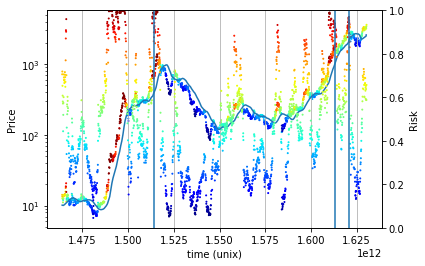

In [63]:
slow_eth=chart.get_sma(eth_weekly,10)
fig, ax1 = plt.subplots()
ax1.set_xlabel('time (unix)')
ax1.set_ylabel('Price')
# ax1.plot(fast['unix'],fast['value'])

risk_eth=chart.risk_indicator(eth,slow_eth)
print(risk_eth.iloc[-1]['value'])
#ax1.plot(eth['unix'],eth['open'])
# ax1.plot(fast['unix'],fast['value'])
ax1.plot(slow_eth['unix'],slow_eth['value'])
ax1.set_yscale('log')
ax1.grid(axis="x")

ax2 = ax1.twinx()
ax2.set_ylabel('Risk')
ax2.vlines([1.514*(10**12),1.613*(10**12), 1.621*(10**12)],ymin=0, ymax=1)
filtered_price_data=eth[eth['unix']>=risk_eth['unix'].min()]
# filtered_risk=risk.loc[risk['value']<0.15]
# ax2.scatter(filtered_risk['unix'],filtered_risk['value'], s=1)
ax2.set_ylim(0,1)
#ax2.vlines(filtered_risk['unix'],0,btc_price_data['close'].max(), colors='r')

ax1.scatter(filtered_price_data['unix'],filtered_price_data['close'], s=1, c=risk_eth['value'], cmap='jet')
ax2.scatter(risk_eth['unix'],risk_eth['value'], s=1, c=risk_eth['value'], cmap='jet')

In [76]:
eth_btc=await get_stored_data('ETH/BTC', '1d')
eth_btc_weekly=price.get_price_data('1w', data=eth_btc)
action=await update_database('ETH/BTC','1d')

AssertionError: Cannot run client.execute(query) if an asyncio loop is running. Use 'await client.execute_async(query)' instead.

0.5639865793978214


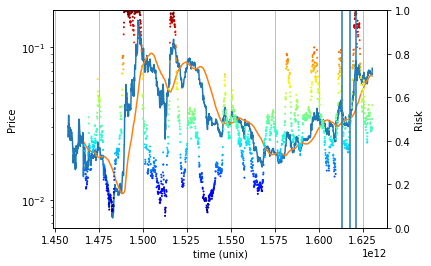

In [74]:
slow_ethbtc=chart.get_sma(eth_btc_weekly,15)
fig, ax1 = plt.subplots()
ax1.set_xlabel('time (unix)')
ax1.set_ylabel('Price')
# ax1.plot(fast['unix'],fast['value'])

risk_ethbtc=chart.risk_indicator(eth_btc, slow_ethbtc)
print(risk_ethbtc['value'].iloc[-1])
ax1.plot(eth_btc['unix'],eth_btc['open'])
# ax1.plot(fast['unix'],fast['value'])
ax1.plot(slow_ethbtc['unix'],slow_ethbtc['value'])
ax1.set_yscale('log')
ax1.grid(axis="x")
ax2 = ax1.twinx()
ax2.set_ylabel('Risk')
ax2.vlines([1.618*(10**12),1.613*(10**12),1.621*(10**12)],ymin=0, ymax=1)
filtered_price_data=eth_btc[eth_btc['unix']>=risk_ethbtc['unix'].min()]
# filtered_risk=risk.loc[risk['value']<0.15]
# ax2.scatter(filtered_risk['unix'],filtered_risk['value'], s=1)
ax2.set_ylim(0,1)
#ax2.vlines(filtered_risk['unix'],0,btc_price_data['close'].max(), colors='r')

# ax1.scatter(filtered_price_data['unix'],filtered_price_data['close'], s=1, c=risk_ethbtc['value'], cmap='jet')
ax2.scatter(risk_ethbtc['unix'],risk_ethbtc['value'], s=1, c=risk_ethbtc['value'], cmap='jet')

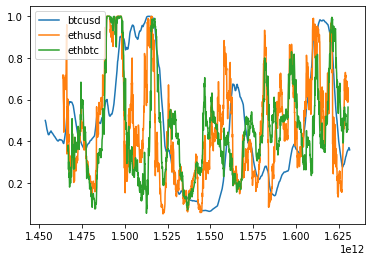

In [12]:
plt.plot(risk['unix'], risk['value'])
plt.plot(risk_eth['unix'], risk_eth['value'])
plt.plot(risk_ethbtc['unix'], risk_ethbtc['value'])
plt.legend(['btcusd','ethusd','ethbtc'])

In [13]:
# fig, ax1 = plt.subplots()
# ax1.set_xlabel('time (unix)')
# ax1.set_ylabel('Price')
# # ax1.plot(fast['unix'],fast['value'])

# risk=conditional_risk(btc_price_data,slow)
# ax1.plot(btc_price_data['unix'],btc_price_data['open'])
# # ax1.plot(fast['unix'],fast['value'])
# ax1.plot(slow['unix'],slow['value'])
# ax1.set_yscale('log')

# ax2 = ax1.twinx()
# ax2.set_ylabel('Risk')
# filtered_price_data=btc_price_data[btc_price_data['unix']>=risk.index.min()]
# # filtered_risk=risk.loc[risk['value']<0.15]
# # ax2.scatter(filtered_risk['unix'],filtered_risk['value'], s=1)
# ax2.set_ylim(risk.values.min(),risk.values.max())
# #ax2.vlines(filtered_risk['unix'],0,btc_price_data['close'].max(), colors='r')

# #ax1.scatter(filtered_price_data['unix'],filtered_price_data['close'], s=1, c=risk, cmap='jet')
# ax2.scatter(risk.index,risk.values, s=1, c=risk.values, cmap='jet')


In [36]:
sol=price.get_price_data('1d','binance',symbol='SOL/USDT')
sol_weekly=price.get_price_data('1w',data=sol)

0.8879751414059387


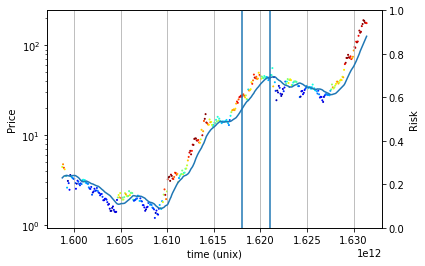

In [37]:
fast_sol=chart.get_ema(sol,5)
slow_sol=chart.get_sma(sol,20)
fig, ax1 = plt.subplots()
ax1.set_xlabel('time (unix)')
ax1.set_ylabel('Price')
# ax1.plot(fast['unix'],fast['value'])

risk_sol=chart.risk_indicator(sol,slow_sol)
print(risk_sol.iloc[-1]['value'])
#ax1.plot(sol['unix'],sol['open'])
# ax1.plot(fast['unix'],fast['value'])
ax1.plot(slow_sol['unix'],slow_sol['value'])
ax1.set_yscale('log')
ax1.grid(axis="x")

ax2 = ax1.twinx()
ax2.set_ylabel('Risk')
ax2.vlines([1.618*(10**12),1.621*(10**12)],ymin=0, ymax=1)
filtered_price_data=sol[sol['unix']>=risk_sol['unix'].min()]
# filtered_risk=risk.loc[risk['value']<0.15]
# ax2.scatter(filtered_risk['unix'],filtered_risk['value'], s=1)
ax2.set_ylim(0,1)
#ax2.vlines(filtered_risk['unix'],0,btc_price_data['close'].max(), colors='r')

ax1.scatter(filtered_price_data['unix'],filtered_price_data['close'], s=1, c=risk_sol['value'], cmap='jet')
#ax2.scatter(risk['unix'],risk['value'], s=1, c=risk['value'], cmap='jet')